In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import scipy

import seaborn as sns

import plot_court
import sklearn.model_selection


sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.5)

Data is from https://github.com/hwchase17/sportvu

In [2]:
full_DatFrame = pd.read_csv('../dat/joined_shots_2013.csv')
full_DatFrame[:3]

,Unnamed: 0,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,DRIBBLES,FGM,FINAL_MARGIN,GAME_CLOCK,GAME_ID,GAME_ID.1,...,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG
0,0,"Turner, Evan",202323.0,1.9,17.0,0.0,10.0,8:09,21300165,21300165,...,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,6.0,-40.0,53.0,1.0,0.0
1,1,"Turner, Evan",202323.0,3.2,0.0,1.0,10.0,9:10,21300165,21300165,...,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26.0,182.0,195.0,1.0,1.0
2,2,"Carter-Williams, Michael",203487.0,3.5,0.0,0.0,10.0,8:36,21300165,21300165,...,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26.0,159.0,206.0,1.0,0.0
3,3,"Brown, Lorenzo",203485.0,3.6,19.0,0.0,10.0,0:23,21300165,21300165,...,Jump Shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,27.0,-15.0,274.0,1.0,0.0
4,0,"Cole, Norris",202708.0,3.7,0.0,1.0,-7.0,11:43,21300230,21300230,...,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,24.0,-149.0,198.0,1.0,1.0
5,1,"Andersen, Chris",2365.0,1.6,13.0,0.0,-7.0,9:36,21300230,21300230,...,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),8-16 ft.,9.0,-98.0,4.0,1.0,0.0
6,2,"Cole, Norris",202708.0,2.4,5.0,0.0,-7.0,8:21,21300230,21300230,...,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,28.0,-100.0,268.0,1.0,0.0
7,0,"Jones, Terrence",203093.0,3.4,6.0,0.0,-6.0,10:48,21300103,21300103,...,Jump Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,3.0,2.0,30.0,1.0,0.0
8,1,"Lin, Jeremy",202391.0,2.4,8.0,0.0,-6.0,10:30,21300103,21300103,...,Jump Shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,21.0,145.0,163.0,1.0,0.0
9,2,"Beverley, Patrick",201976.0,3.5,2.0,1.0,-6.0,8:26,21300103,21300103,...,Pullup Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18.0,-97.0,153.0,1.0,1.0


In [3]:
full_DatFrame.keys()

Index(['Unnamed: 0', 'CLOSEST_DEFENDER', 'CLOSEST_DEFENDER_PLAYER_ID',
       'CLOSE_DEF_DIST', 'DRIBBLES', 'FGM', 'FINAL_MARGIN', 'GAME_CLOCK',
       'GAME_ID', 'GAME_ID.1', 'LOCATION', 'MATCHUP', 'PERIOD', 'PERIOD.1',
       'PTS', 'PTS_TYPE', 'SHOT_CLOCK', 'SHOT_DIST', 'SHOT_NUMBER',
       'SHOT_RESULT', 'TOUCH_TIME', 'W', 'GRID_TYPE', 'GAME_EVENT_ID',
       'PLAYER_ID', 'PLAYER_ID.1', 'PLAYER_NAME', 'TEAM_ID',
       'MINUTES_REMAINING', 'SECONDS_REMAINING', 'EVENT_TYPE', 'ACTION_TYPE',
       'SHOT_TYPE', 'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE',
       'SHOT_DISTANCE', 'LOC_X', 'LOC_Y', 'SHOT_ATTEMPTED_FLAG',
       'SHOT_MADE_FLAG'],
      dtype='object')

In [4]:
df = pd.DataFrame(full_DatFrame, 
                  columns = ['PLAYER_ID.1', 'PLAYER_NAME', 
                             'MATCHUP', 'LOCATION', 'TEAM_ID', 
                             'SHOT_DISTANCE', 
                             'PTS_TYPE', 'LOC_X', 'LOC_Y', 
                             'ACTION_TYPE', 'SHOT_TYPE',
                             'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG'])
df[:3]

,PLAYER_ID.1,PLAYER_NAME,MATCHUP,LOCATION,TEAM_ID,SHOT_DISTANCE,PTS_TYPE,LOC_X,LOC_Y,ACTION_TYPE,SHOT_TYPE,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG
0,202779,Dwight Buycks,"NOV 20, 2013 - TOR @ PHI",A,1.610613e+09,6.0,2.0,-40.0,53.0,Jump Shot,2PT Field Goal,1.0,0.0
1,202779,Dwight Buycks,"NOV 20, 2013 - TOR @ PHI",A,1.610613e+09,26.0,3.0,182.0,195.0,Jump Shot,3PT Field Goal,1.0,1.0
2,202779,Dwight Buycks,"NOV 20, 2013 - TOR @ PHI",A,1.610613e+09,26.0,3.0,159.0,206.0,Jump Shot,3PT Field Goal,1.0,0.0
3,202779,Dwight Buycks,"NOV 20, 2013 - TOR @ PHI",A,1.610613e+09,27.0,3.0,-15.0,274.0,Jump Shot,3PT Field Goal,1.0,0.0
4,202779,Dwight Buycks,"NOV 29, 2013 - TOR vs. MIA",H,1.610613e+09,24.0,3.0,-149.0,198.0,Jump Shot,3PT Field Goal,1.0,1.0
5,202779,Dwight Buycks,"NOV 29, 2013 - TOR vs. MIA",H,1.610613e+09,9.0,2.0,-98.0,4.0,Jump Shot,2PT Field Goal,1.0,0.0
6,202779,Dwight Buycks,"NOV 29, 2013 - TOR vs. MIA",H,1.610613e+09,28.0,3.0,-100.0,268.0,Jump Shot,3PT Field Goal,1.0,0.0
7,202779,Dwight Buycks,"NOV 11, 2013 - TOR @ HOU",A,1.610613e+09,3.0,2.0,2.0,30.0,Jump Shot,2PT Field Goal,1.0,0.0
8,202779,Dwight Buycks,"NOV 11, 2013 - TOR @ HOU",A,1.610613e+09,21.0,2.0,145.0,163.0,Jump Shot,2PT Field Goal,1.0,0.0
9,202779,Dwight Buycks,"NOV 11, 2013 - TOR @ HOU",A,1.610613e+09,18.0,2.0,-97.0,153.0,Pullup Jump shot,2PT Field Goal,1.0,1.0


In [5]:
teamID_dict = plot_court.out_teamsDict()

{1610612737: {'abbreviation': 'ATL',
  'location': 'Atlanta',
  'simpleName': 'Hawks',
  'teamId': 1610612737,
  'teamName': 'Atlanta Hawks'},
 'ATL': {'abbreviation': 'ATL',
  'location': 'Atlanta',
  'simpleName': 'Hawks',
  'teamId': 1610612737,
  'teamName': 'Atlanta Hawks'},
 1610612738: {'abbreviation': 'BOS',
  'location': 'Boston',
  'simpleName': 'Celtics',
  'teamId': 1610612738,
  'teamName': 'Boston Celtics'},
 'BOS': {'abbreviation': 'BOS',
  'location': 'Boston',
  'simpleName': 'Celtics',
  'teamId': 1610612738,
  'teamName': 'Boston Celtics'},
 1610612751: {'abbreviation': 'BKN',
  'location': 'Brooklyn',
  'simpleName': 'Nets',
  'teamId': 1610612751,
  'teamName': 'Brooklyn Nets'},
 'BKN': {'abbreviation': 'BKN',
  'location': 'Brooklyn',
  'simpleName': 'Nets',
  'teamId': 1610612751,
  'teamName': 'Brooklyn Nets'},
 1610612766: {'abbreviation': 'CHA',
  'location': 'Charlotte',
  'simpleName': 'Hornets',
  'teamId': 1610612766,
  'teamName': 'Charlotte Hornets'},
 '

In [6]:
plot_court.out_teamsDict(team_abbrev='ORL')['teamId']

1610612753

In [7]:
def out_teamAbbrev(teamID):
    teamID_dict = plot_court.out_teamsDict()
    return teamID_dict[teamID]['abbreviation']

df['TEAM_ABBREV'] = pd.Series(map(out_teamAbbrev, df.TEAM_ID), index=df.index)
df[:3]

,PLAYER_ID.1,PLAYER_NAME,MATCHUP,LOCATION,TEAM_ID,SHOT_DISTANCE,PTS_TYPE,LOC_X,LOC_Y,ACTION_TYPE,SHOT_TYPE,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,TEAM_ABBREV
0,202779,Dwight Buycks,"NOV 20, 2013 - TOR @ PHI",A,1.610613e+09,6.0,2.0,-40.0,53.0,Jump Shot,2PT Field Goal,1.0,0.0,TOR
1,202779,Dwight Buycks,"NOV 20, 2013 - TOR @ PHI",A,1.610613e+09,26.0,3.0,182.0,195.0,Jump Shot,3PT Field Goal,1.0,1.0,TOR
2,202779,Dwight Buycks,"NOV 20, 2013 - TOR @ PHI",A,1.610613e+09,26.0,3.0,159.0,206.0,Jump Shot,3PT Field Goal,1.0,0.0,TOR
3,202779,Dwight Buycks,"NOV 20, 2013 - TOR @ PHI",A,1.610613e+09,27.0,3.0,-15.0,274.0,Jump Shot,3PT Field Goal,1.0,0.0,TOR
4,202779,Dwight Buycks,"NOV 29, 2013 - TOR vs. MIA",H,1.610613e+09,24.0,3.0,-149.0,198.0,Jump Shot,3PT Field Goal,1.0,1.0,TOR
5,202779,Dwight Buycks,"NOV 29, 2013 - TOR vs. MIA",H,1.610613e+09,9.0,2.0,-98.0,4.0,Jump Shot,2PT Field Goal,1.0,0.0,TOR
6,202779,Dwight Buycks,"NOV 29, 2013 - TOR vs. MIA",H,1.610613e+09,28.0,3.0,-100.0,268.0,Jump Shot,3PT Field Goal,1.0,0.0,TOR
7,202779,Dwight Buycks,"NOV 11, 2013 - TOR @ HOU",A,1.610613e+09,3.0,2.0,2.0,30.0,Jump Shot,2PT Field Goal,1.0,0.0,TOR
8,202779,Dwight Buycks,"NOV 11, 2013 - TOR @ HOU",A,1.610613e+09,21.0,2.0,145.0,163.0,Jump Shot,2PT Field Goal,1.0,0.0,TOR
9,202779,Dwight Buycks,"NOV 11, 2013 - TOR @ HOU",A,1.610613e+09,18.0,2.0,-97.0,153.0,Pullup Jump shot,2PT Field Goal,1.0,1.0,TOR


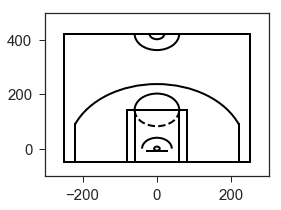

In [8]:
plt.figure(figsize=(4,3))
plot_court.draw_court(outer_lines=True)
plt.xlim(-300,300)
plt.ylim(-100,500)
plt.show()

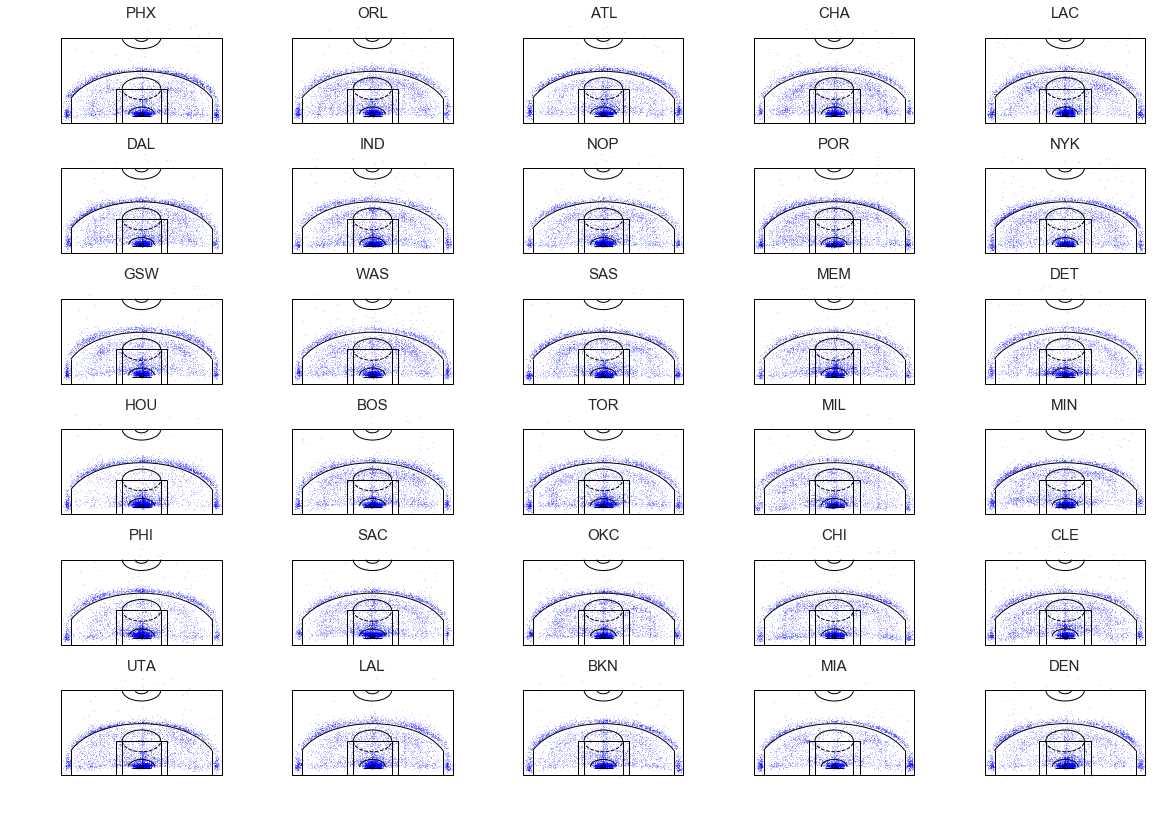

In [16]:
plt.figure(figsize=(20,14))
for i, team_abbrev in enumerate(set(df.TEAM_ABBREV)):
    plt.subplot(6, 5, i+1)
    plot_court.draw_court(outer_lines=True, lw=1.)
    
    temp = df[df.TEAM_ABBREV == team_abbrev]
    plt.scatter(temp.LOC_X, temp.LOC_Y, s=0.1, c='blue', alpha=0.5)
    
    plt.xlim(-300,300)
    plt.ylim(-100,500)
    plt.title('%s'%(team_abbrev), fontsize=15)
    plt.axis('off')
plt.show()

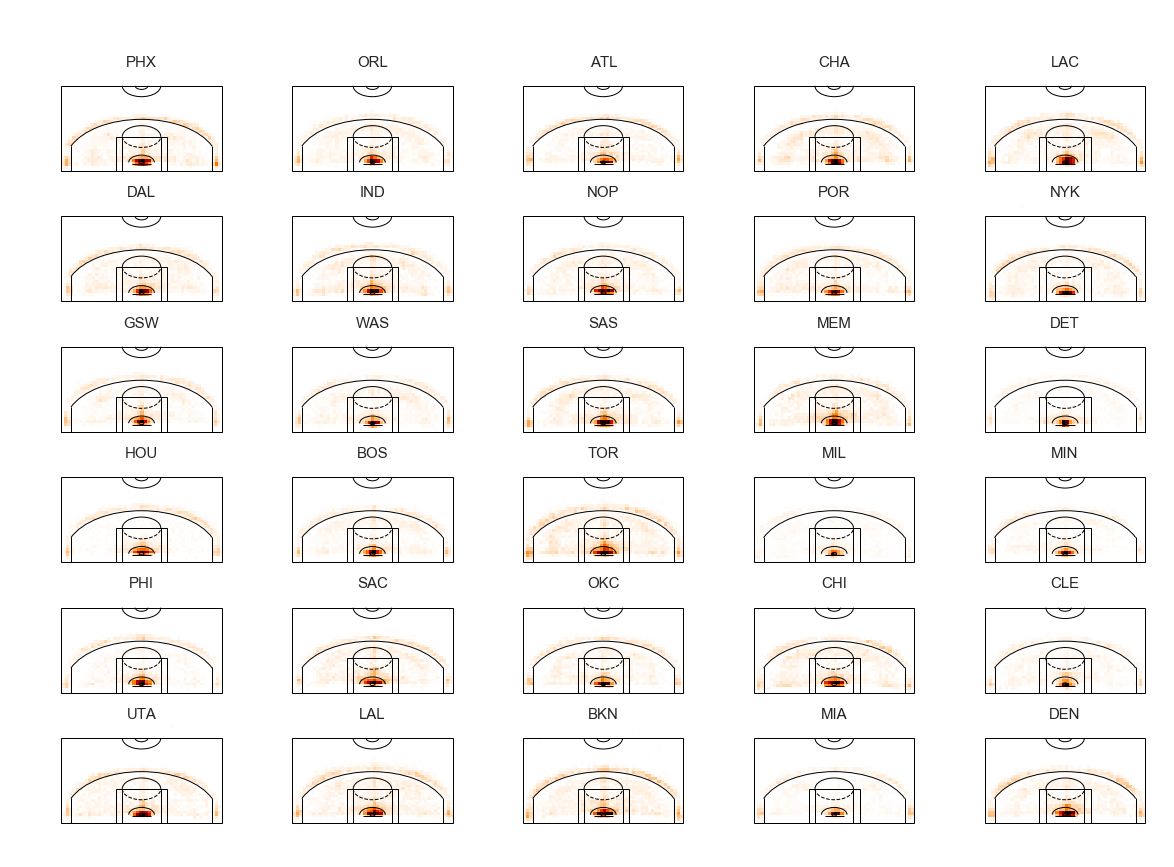

In [31]:
plt.figure(figsize=(20,14))
for i, team_abbrev in enumerate(set(df.TEAM_ABBREV)):
    plt.subplot(6, 5, i+1)
    plot_court.draw_court(outer_lines=True, lw=1.)
    
    temp = df[df.TEAM_ABBREV == team_abbrev]
    plt.hist2d(temp.LOC_X, temp.LOC_Y, bins=[50,47], cmap=plt.cm.gist_heat_r)
    
    plt.xlim(-300,300)
    plt.ylim(-100,500)
    plt.title('%s'%(team_abbrev), fontsize=15)
    plt.axis('off')
plt.show()

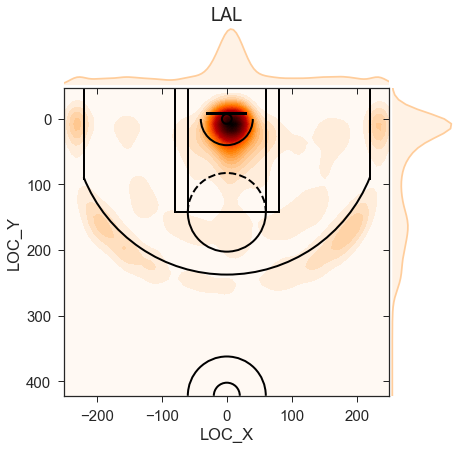

In [25]:
team_abrv = 'LAL'
temp = df[df.TEAM_ABBREV == team_abbrev]

cmap=plt.cm.gist_heat_r
joint_shot_chart = sns.jointplot(temp.LOC_X, temp.LOC_Y, 
                                    stat_func=None,
                                    kind='kde', space=0, color=cmap(0.1),
                                    cmap=cmap, n_levels=50)
joint_shot_chart.fig.set_size_inches(7, 6.5)
ax = joint_shot_chart.ax_joint
plot_court.draw_court(ax)

ax.set_xlim(-250,250)
ax.set_ylim(422.5, -47.5)
ax.set_title(team_abrv, 
             y=1.2, fontsize=18)

plt.show()

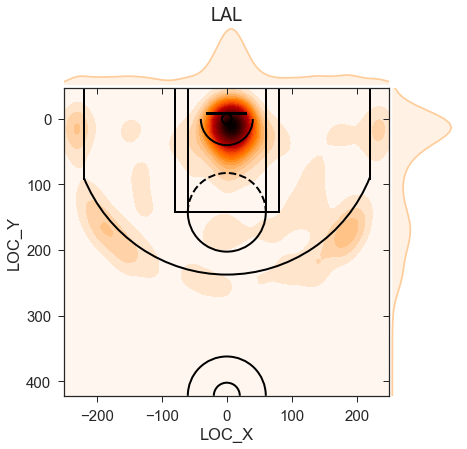

In [22]:
team_abrv = 'LAL'
temp = df[df.TEAM_ABBREV == team_abbrev]
train, test = sklearn.model_selection.train_test_split(temp, test_size = 0.2)


cmap=plt.cm.gist_heat_r
joint_shot_chart = sns.jointplot(test.LOC_X, test.LOC_Y, 
                                    stat_func=None,
                                    kind='kde', space=0, color=cmap(0.1),
                                    cmap=cmap, n_levels=30)
joint_shot_chart.fig.set_size_inches(7, 6.5)
ax = joint_shot_chart.ax_joint
plot_court.draw_court(ax)

ax.set_xlim(-250,250)
ax.set_ylim(422.5, -47.5)
ax.set_title(team_abrv, 
             y=1.2, fontsize=18)

plt.show()

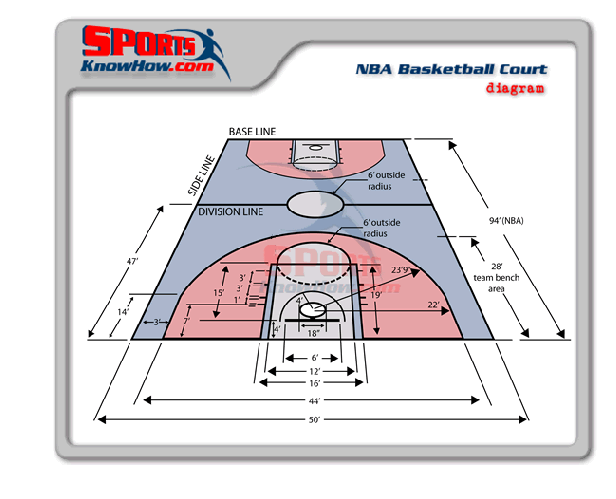

In [27]:
import urllib.request
# we pass in the link to the image as the 1st argument
# the 2nd argument tells urlretrieve what we want to scrape
pic = urllib.request.urlretrieve("http://www.sportsknowhow.com/wp-content/uploads/2015/03/basketball-NBA-court-dimensions-diagram-lrg.gif",
                                "basketball-NBA-court-dimensions-diagram-lrg.gif")

# urlretrieve returns a tuple with our image as the first 
# element and imread reads in the image as a 
# mutlidimensional numpy array so matplotlib can plot it
courtDim_pic = plt.imread(pic[0])

# plot the image
plt.figure(figsize=(10,10))
plt.imshow(courtDim_pic)
plt.axis('off')
plt.show()

In [41]:
hist2d, xedges, yedges, binnumber = scipy.stats.binned_statistic_2d(train.LOC_X, train.LOC_Y, train.SHOT_MADE_FLAG,
                                                                    statistic='count',
                                                                    bins=[50,47], range=[[-250,250], [-47.5,422.5]])
hist2d

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  3., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  3., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [40]:
np.shape(hist2d)

(50, 47)

In [43]:
np.sum(hist2d)

5519.0

In [44]:
import emcee

ModuleNotFoundError: No module named 'emcee'